<a href="https://colab.research.google.com/github/KaranSantra/ChaiBachai/blob/main/Rim_Detection_Pot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
%pip install "ultralytics<=8.3.40" supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.7/107.7 GB disk)


In [ ]:
# prompt: give command to fetch a file from my google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
trainedModel=f"{HOME}/drive/MyDrive/Tea-boiling-over/best-pot-detection-yolo11s-6.pt"
testFolder = f"{HOME}/drive/MyDrive/Tea-boiling-over/test-images"

In [ ]:
# prompt: how to extract the bounding box dimensions from the images
# !yolo task=detect mode=predict model={trainedModel} conf=0.5 source={testFolder} save=True

import os
import ultralytics
from ultralytics import YOLO

# ... (your existing code)

results = model.predict(source=testFolder, save=True, conf=0.5)

for r in results:
    boxes = r.boxes  # Boxes object for bbox outputs
    for box in boxes:
        b = box.xyxy[0]  # get box coordinates in (top, left, bottom, right) format
        width = b[2] - b[0]
        height = b[3] - b[1]

        print(f"Bounding box dimensions: Width = {width:.2f}, Height = {height:.2f}")
        # You can access other information from box object like confidence score, class id etc.
        #print(box.conf) # confidence score
        #print(box.cls)  # class id

In [ ]:
# prompt: wrap this line to show time a performance
import os
import time
start_time = time.time()
!yolo task=detect mode=predict model={trainedModel} conf=0.5 source={testFolder} save=True
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
YOLO11s summary (fused): 238 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs

image 1/3 /content/drive/MyDrive/Tea-boiling-over/test-images/test-1.jpg: 192x256 1 pot, 94.3ms
image 2/3 /content/drive/MyDrive/Tea-boiling-over/test-images/test-3.jpg: 192x256 1 pot, 79.1ms
image 3/3 /content/drive/MyDrive/Tea-boiling-over/test-images/test4.jpg: 160x256 2 pots, 78.4ms
Speed: 0.9ms preprocess, 83.9ms inference, 1.0ms postprocess per image at shape (1, 3, 160, 256)
Results saved to runs/detect/predict2
💡 Learn more at https://docs.ultralytics.com/modes/predict
Elapsed time: 7.45 seconds


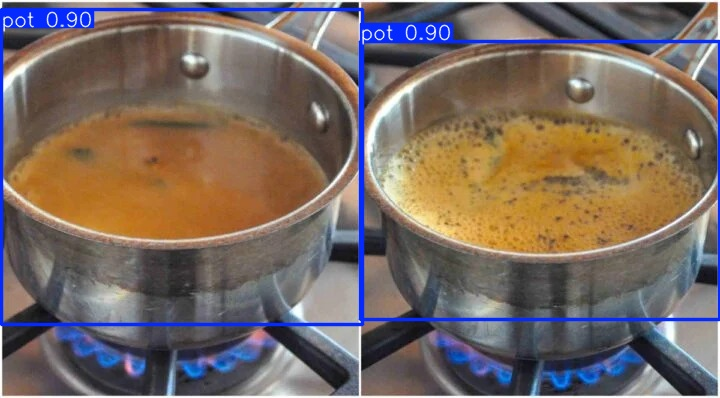

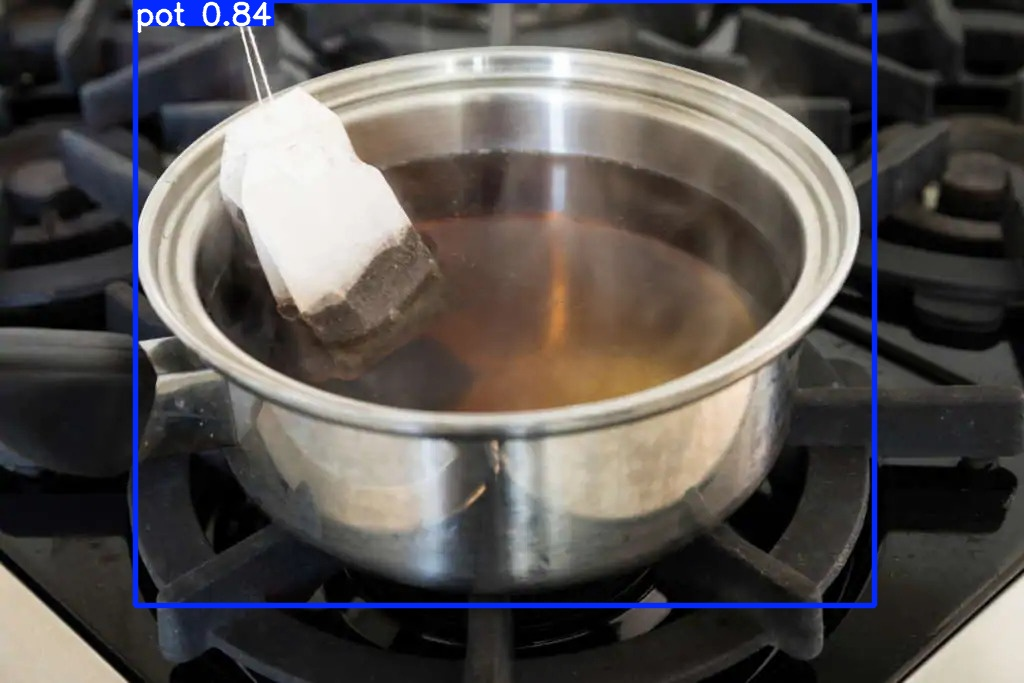

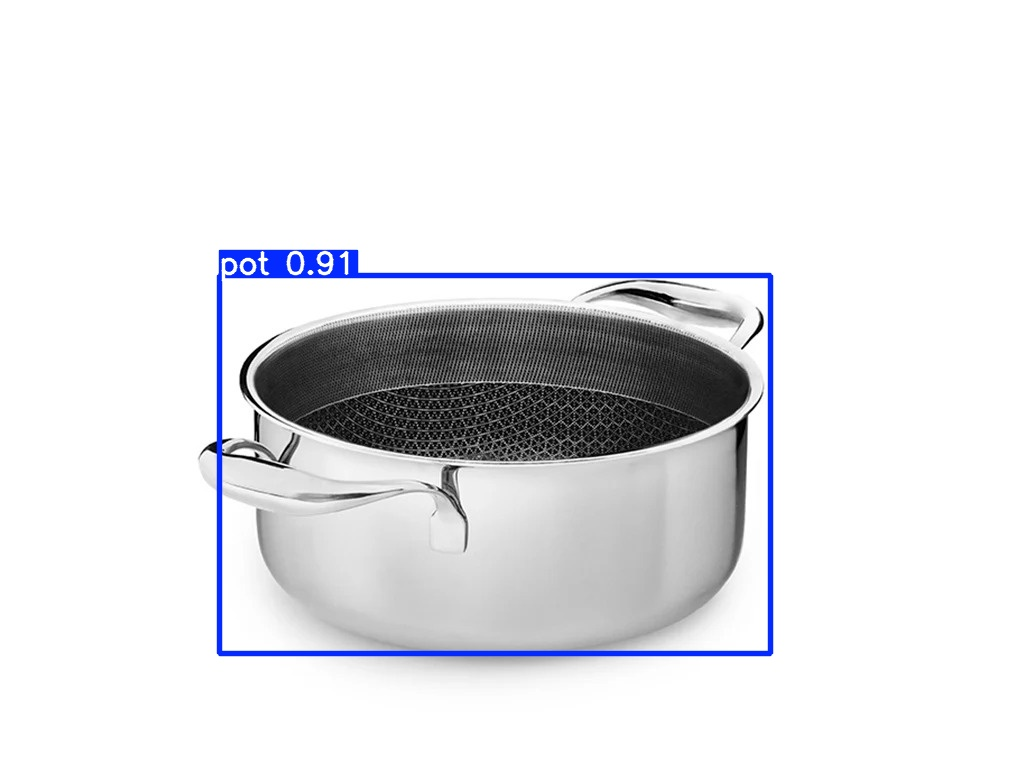

In [ ]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob(f'{HOME}/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:]:
    display(IPyImage(filename=img, width=600))
    print("\n")

In [ ]:
import cv2
import numpy as np

def detect_rim_with_hough_and_contours(image, pot_bbox):
    """
    Detects the rim of a pot using Hough Circle Transform augmented with contour analysis.

    Args:
        image: Input image (BGR).
        pot_bbox: Tuple containing bounding box coordinates of the pot (x_min, y_min, x_max, y_max).

    Returns:
        rim_line: Y-coordinate of the detected rim.
        output_image: Image with rim detection drawn.
    """
    # Extract bounding box coordinates
    x_min, y_min, x_max, y_max = pot_bbox

    # Crop the region of interest (ROI) around the pot
    ROI = image[y_min:y_max, x_min:x_max]

    # Convert ROI to grayscale and apply Gaussian blur
    gray = cv2.cvtColor(ROI, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Edge detection using Canny
    edges = cv2.Canny(blurred, 50, 150)

    # Mask the top portion of the pot (top 30% of ROI)
    mask = np.zeros_like(edges)
    box_height = y_max - y_min
    top_mask_height = int(0.3 * box_height)
    mask[:top_mask_height, :] = 255
    rim_edges = cv2.bitwise_and(edges, edges, mask=mask)

    # Apply Hough Circle Transform
    circles = cv2.HoughCircles(
        rim_edges,
        cv2.HOUGH_GRADIENT,
        dp=1.2,
        minDist=20,
        param1=50,
        param2=30,
        minRadius=10,  # Adjust based on expected pot sizes
        maxRadius=100
    )

    # Initialize variables
    rim_line = None
    output_image = ROI.copy()

    if circles is not None:
        # Convert circle coordinates to integers
        circles = np.uint16(np.around(circles))
        for circle in circles[0, :]:
            x, y, r = circle
            # Draw the detected circle
            cv2.circle(output_image, (x, y), r, (0, 255, 0), 2)
            rim_line = int(y - r)  # Top edge of the circle
            break  # Use the first detected circle

    # If no circle is detected, fall back to contour-based detection
    if rim_line is None:
        # Find contours in the edge-detected image
        contours, _ = cv2.findContours(rim_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            # Find the largest contour
            largest_contour = max(contours, key=cv2.contourArea)
            # Fit a bounding rectangle to the contour and use the top edge
            x, y, w, h = cv2.boundingRect(largest_contour)
            rim_line = y  # Top of the bounding box
            # Draw the contour and bounding rectangle
            cv2.drawContours(output_image, [largest_contour], -1, (255, 0, 0), 2)
            cv2.rectangle(output_image, (x, y), (x + w, y + h), (255, 0, 0), 2)

    # Draw the detected rim line on the output image
    if rim_line is not None:
        cv2.line(output_image, (0, rim_line), (output_image.shape[1], rim_line), (0, 0, 255), 2)

    return rim_line, output_image


# Example usage
if __name__ == "__main__":
    # Load an image (replace 'pot_image.jpg' with your test image)
    image = cv2.imread("pot_image.jpg")

    # Example bounding box coordinates from YOLOv11s model
    pot_bbox = (50, 100, 300, 400)  # Replace with actual YOLO output

    # Detect the rim
    rim_line, output_image = detect_rim_with_hough_and_contours(image, pot_bbox)

    # Display the result
    cv2.imshow("Detected Rim", output_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
